<a href="https://colab.research.google.com/github/k3rnel-paN1c5/deep-vision/blob/main/KnowledgeDistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [ ]:
# Install TorchDistill (PyTorch-based KD framework)
%pip install torchdistill

# Install PyTorch and dependencies
%pip install torch torchvision

# Install Hugging Face Transformers for model loading
%pip install transformers

# Install dataset tools
%pip install datasets
# for image Processiing
%pip install opencv-python

In [3]:
import torch
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
from transformers import pipeline
import torchdistill
import PIL
import requests
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np


print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("TorchDistill version:", torchdistill.__version__)

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
TorchDistill version: 1.1.3


In [4]:
# Load teacher model (Distill-Any-Depth-Large)
# teacher_model = pipeline(task="depth-estimation", model="xingyang1/Distill-Any-Depth-Large-hf")
# Load Student model (Depth-Anything-V2-Small)
# student_model = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")


# Load teacher model (distill-any-depth)
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to("cuda")

# Load student model (depth-anything-v2-small)
student = AutoModelForDepthEstimation.from_pretrained("xingyang1/Distill-Any-Depth-Small-hf").to("cuda")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

Testing using pipline model

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UnlabeledDepthDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define transforms (match teacher/student input requirements)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Common depth model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Optimizer
optimizer = optim.AdamW(student.parameters(), lr=3e-4)

# Create dataset/loader
dataset = UnlabeledDepthDataset("/content/drive/MyDrive/images", transform=transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

In [7]:
# Define loss (KL Divergence + optional MSE for depth maps)
temperature = 4.0
alpha = 0.7  # Weight for distillation loss
# hard_loss = nn.MSELoss()
soft_loss = nn.KLDivLoss(reduction="batchmean")

In [8]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Preprocess (match training transforms)
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Input size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

In [9]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Student prediction
    student_depth_before_training = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

In [10]:
# Training loop
teacher.eval()  # Teacher is frozen
student.train()

DepthAnythingForDepthEstimation(
  (backbone): Dinov2Backbone(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Di

In [10]:
for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Teacher forward pass (no gradients)
        with torch.no_grad():

            teacher_outputs = teacher(inputs).predicted_depth  # Assuming logits are the depth map

        # Student forward pass
        student_outputs = student(inputs).predicted_depth


        # Distillation loss (soft targets)
        soft_targets = nn.functional.softmax(teacher_outputs / temperature, dim=1)
        student_log_probs = nn.functional.log_softmax(student_outputs / temperature, dim=1)
        distill_loss = soft_loss(student_log_probs, soft_targets) * (temperature ** 2)

        # Optional: Add hard loss if you have ground-truth labels
        # hard_loss_value = hard_loss(student_outputs, ground_truth_depth)

        # Total loss (only distillation here)
        total_loss = distill_loss * alpha  # + hard_loss_value * (1 - alpha)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")

Epoch 1/50 | Loss: 8831.1543
Epoch 2/50 | Loss: 10114.9023
Epoch 3/50 | Loss: 5941.8940
Epoch 4/50 | Loss: 7925.8481
Epoch 5/50 | Loss: 5455.2051
Epoch 6/50 | Loss: 7163.5977
Epoch 7/50 | Loss: 8065.1885
Epoch 8/50 | Loss: 8005.7427
Epoch 9/50 | Loss: 8895.9707
Epoch 10/50 | Loss: 7587.4448
Epoch 11/50 | Loss: 7812.3794
Epoch 12/50 | Loss: 7878.2471
Epoch 13/50 | Loss: 6561.3364
Epoch 14/50 | Loss: 6728.3350
Epoch 15/50 | Loss: 15573.5674
Epoch 16/50 | Loss: 10428.5996
Epoch 17/50 | Loss: 7915.7544
Epoch 18/50 | Loss: 6045.8276
Epoch 19/50 | Loss: 5966.5420
Epoch 20/50 | Loss: 8856.4014
Epoch 21/50 | Loss: 8750.4355
Epoch 22/50 | Loss: 6217.7490
Epoch 23/50 | Loss: 4004.2952
Epoch 24/50 | Loss: 7519.6699
Epoch 25/50 | Loss: 6192.7490
Epoch 26/50 | Loss: 4757.4087
Epoch 27/50 | Loss: 5944.2583
Epoch 28/50 | Loss: 3568.9070
Epoch 29/50 | Loss: 4657.3457
Epoch 30/50 | Loss: 7756.6328
Epoch 31/50 | Loss: 4807.3521
Epoch 32/50 | Loss: 3895.7051
Epoch 33/50 | Loss: 5152.4292
Epoch 34/50 | Lo

In [12]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Teacher prediction
    teacher_depth = teacher(input_tensor).predicted_depth.squeeze().cpu().numpy()

    # Student prediction
    student_depth = student(input_tensor).predicted_depth.squeeze().cpu().numpy()

# Before Training

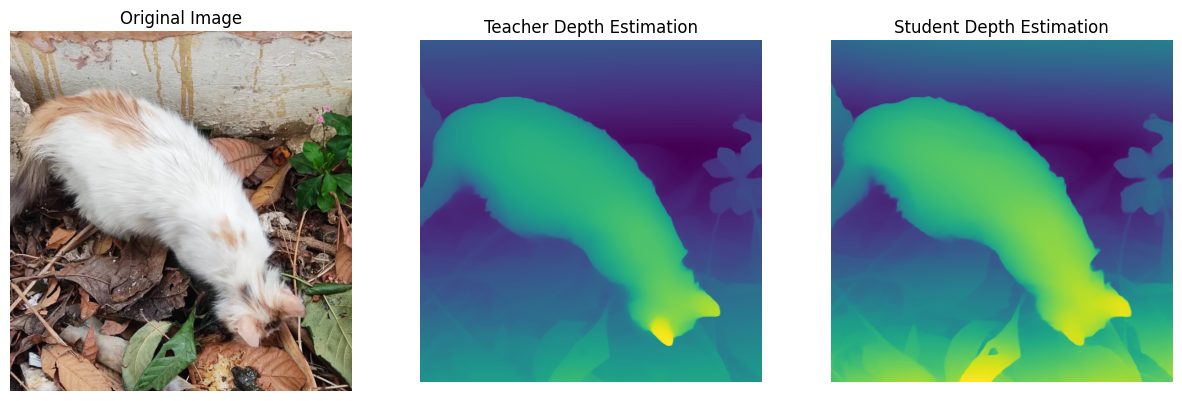

In [13]:
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# After Training

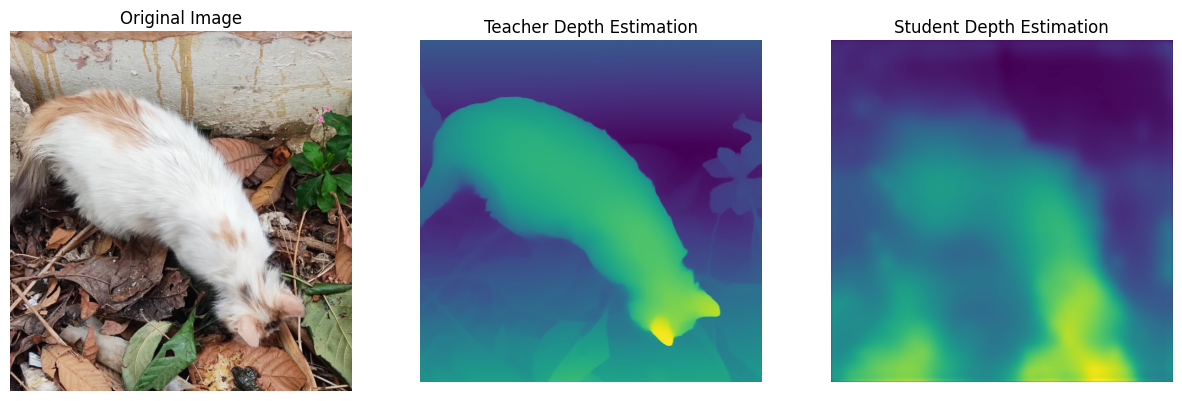

In [14]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

In [ ]:
# from torchdistill.core.distillation import DistillationBox
# from torchdistill.datasets.util import build_data_loaders

# import yaml

# # Load YAML config file into a dictionary
# with open("config.yaml", "r") as f:
#     config_dict = yaml.safe_load(f)

# # Initialize distillation

# distiller = DistillationBox(
#     teacher_model=teacher,
#     student_model=student,
#     dataset_dict={"train": dataloader, "val": None},
#     device_ids=[0],
#     distributed=False,
#     lr_factor=1.0,
#     train_config=config_dict,
#     device="cuda"
# )

# # Training loop
# for epoch in range(30):
#     for batch in dataloader:
#         inputs = batch.to("cuda")

#         # Forward pass through teacher (no labels needed)
#         with torch.no_grad():
#             teacher_outputs = teacher(inputs)

#         # Forward pass through student
#         student_outputs = student(inputs)

#         # Compute distillation loss
#         loss = distiller.criterion(
#             student_outputs=student_outputs,
#             teacher_outputs=teacher_outputs,
#             inputs=inputs
#         )

#         # Backpropagation
#         distiller.optimizer.zero_grad()
#         loss.backward()
#         distiller.optimizer.step()

#     print(f"Epoch {epoch+1}/30 | Loss: {loss.item():.4f}")

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
from torchdistill.losses import util
from torchdistill.models.registry import get_model

# Load teacher and student models
teacher = get_model("Depth-Anything-V2-Large-hf", pretrained=True)  # Replace with your teacher architecture
student = get_model("Distill-Any-Depth-Small-hf", pretrained=True)  # Replace with your student architecture

# Define distillation loss (e.g., KL divergence for soft targets)
# distill_criterion = util.get_criterion("kl_div", temperature=temperature)  # Uses softmax


In [11]:
# from torchdistill.train.util import train_one_epoch

for epoch in range(50):
    for batch in dataloader:
        inputs = batch.to("cuda")

        # Forward passes
        with torch.no_grad():
            teacher_outputs = teacher(inputs).predicted_depth

        student_outputs = student(inputs).predicted_depth

        # Compute loss
        total_loss = nn.functional.mse_loss(student_outputs, teacher_outputs)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/50 | Loss: {total_loss.item():.4f}")

Epoch 1/50 | Loss: 12579.1592
Epoch 2/50 | Loss: 11074.5977
Epoch 3/50 | Loss: 10383.3945
Epoch 4/50 | Loss: 20116.4414
Epoch 5/50 | Loss: 9967.1494
Epoch 6/50 | Loss: 8642.7197
Epoch 7/50 | Loss: 6752.7505
Epoch 8/50 | Loss: 8127.3809
Epoch 9/50 | Loss: 12873.4004
Epoch 10/50 | Loss: 12399.4443
Epoch 11/50 | Loss: 9921.5664
Epoch 12/50 | Loss: 12235.6270
Epoch 13/50 | Loss: 17896.7598
Epoch 14/50 | Loss: 10815.9297
Epoch 15/50 | Loss: 9437.7305
Epoch 16/50 | Loss: 5574.8403
Epoch 17/50 | Loss: 9718.4062
Epoch 18/50 | Loss: 8085.4741
Epoch 19/50 | Loss: 6016.9824
Epoch 20/50 | Loss: 12638.5801
Epoch 21/50 | Loss: 8831.7881
Epoch 22/50 | Loss: 7241.9863
Epoch 23/50 | Loss: 7094.4478
Epoch 24/50 | Loss: 10356.5039
Epoch 25/50 | Loss: 9883.0654
Epoch 26/50 | Loss: 6195.0913
Epoch 27/50 | Loss: 5238.8394
Epoch 28/50 | Loss: 3491.3828
Epoch 29/50 | Loss: 5733.9946
Epoch 30/50 | Loss: 5450.7915
Epoch 31/50 | Loss: 9590.7754
Epoch 32/50 | Loss: 6231.8145
Epoch 33/50 | Loss: 7927.9150
Epoch 34